## Part 1

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, \
    roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import subplots, show
from functools import reduce
from seaborn import lineplot
from math import tanh
import pandas as pd
import numpy as np


# Util Functions
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
  return sigmoid(x) * (1 - sigmoid(x))

def cross_entropy_error_function(target, y_hat):
  return -np.sum( target * np.log(y_hat) + (1 - target) * np.log(1 - y_hat))

def error_gradient(target, y_hat):
  return -np.divide(target, y_hat) + np.divide(1 - target, 1 - y_hat)

def tanh_derivative(x):
  return 1 - tanh(x) ** 2


# Neural Network Implementation
class neural_network():
    # Constructor
    def __init__(self):
        self.A0 = self.A1 = self.A2 = self.Z1 = self.Z2 = self.W1 = self.W2 = 0

    # Training Function
    def train(self, data, epochs = 120, lr = 0.005):
        W1 = np.random.random((1, 3))
        W2 = np.random.random((1, 4))
        error = []
        for epoch in range(epochs):
            error_row = np.zeros(len(data))
            for idx, row in enumerate(data):
                x_i = row[:-1]
                y_i = row[-1]
                # Forward Pass
                A0 = np.append(x_i[:2], 1).reshape(1, -1).T
                Z1 = W1 @ A0
                A1 = tanh(Z1)
                A1 = reduce(lambda x, y: np.append(x, y),
                            [A1, x_i[2:], 1]).reshape(1, -1).T
                Z2 = W2 @ A1
                A2 = sigmoid(Z2).reshape(1, -1).T
                # Backward Pass
                dA2 = error_gradient(y_i, A2)
                dZ2 = dA2 * sigmoid_derivative(Z2)
                dW2 = dZ2[0] @ A1.T
                dA1 = W2[:, :-1].T @ dZ2
                dZ1 = dA1 * tanh_derivative(Z1)
                dW1 = dZ1[0] @ A0.T
                # Weight Update
                W1 -= lr * dW1
                W2 -= lr * dW2
                error_row[idx] = cross_entropy_error_function(y_i, A2)
            # Error
            error.append(np.mean(error_row))
        self.A0, self.A1, self.A2 = A0, A1, A2
        self.Z1, self.Z2 = Z1, Z2
        self.W1, self.W2 = W1, W2
        return error

    # Predicting Function
    def predict(self, data):
        A0, A1, A2 = self.A0, self.A1, self.A2
        Z1, Z2 = self.Z1, self.Z2
        W1, W2 = self.W1, self.W2
        pred = []
        for x_i in data:
            A0 = np.append(x_i[:2], 1).reshape(1, -1).T
            Z1 = W1 @ A0
            A1 = tanh(Z1)
            A1 = reduce(lambda x, y: np.append(x, y),
                        [A1, x_i[2:], 1]).reshape(1, -1).T
            Z2 = W2 @ A1
            A2 = sigmoid(Z2).reshape(1, -1).T
            pred.append(round(A2[0,0]))
        return np.array(pred)

In [2]:
# Loading and preparing data
df = pd.read_csv("Part_1.tsv", sep="\t")
train, test = map(lambda x: np.array(x), train_test_split(df, test_size=.3))

# Creating and Training Neural Network
nn = neural_network()
error = nn.train(train)

In [3]:
# Predicting test labels
predicted = nn.predict(test[:,:-1])

# Real labels
actual = test[:, -1]

In [4]:
from tabulate import tabulate

# Calculating metrics
metrics = {'accuracy': accuracy_score(actual, predicted),
           'auc_pr': average_precision_score(actual, predicted),
           'auc_roc': roc_auc_score(actual, predicted)}
cm = confusion_matrix(actual, predicted)


# Printing results
print("Metrics:")
print(tabulate([metrics.keys(), metrics.values()],
               headers='firstrow', tablefmt='fancy_grid'))
print("\nConfusion Matrix:")
print(tabulate(cm, headers='firstrow', tablefmt='fancy_grid'))

Metrics:
╒════════════╤══════════╤═══════════╕
│   accuracy │   auc_pr │   auc_roc │
╞════════════╪══════════╪═══════════╡
│   0.895667 │ 0.850332 │  0.894711 │
╘════════════╧══════════╧═══════════╛

Confusion Matrix:
╒════════╤═══════╕
│   1255 │   202 │
╞════════╪═══════╡
│    111 │  1432 │
╘════════╧═══════╛


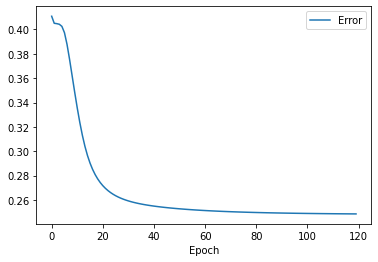

In [5]:
# Plotting error by Epoch
fig, ax = subplots()
lineplot(x=range(len(error)), y=error, ax=ax, label='Error')
ax.set_xlabel('Epoch')
show()

## Part 2

In [6]:
# Implementation of bagged trees model
# (some functions will also be used in random trees model)

import pandas as pd
import numpy as np

def data_prep(filename, delimiter=',', data_split=0.7, random_state=42):
    """Prepare the dataset to process, separating training and testing samples.
    Imputs are the file to be importer, the delimiter, data split for training
    set and random state. Returns train, test and data arrays"""
    df = pd.read_csv(filename, delimiter = delimiter)
    if df.iloc[:,-1].dtype != 'int64':
        df_classes = df.iloc[:,-1].unique()
        class_key = {}
        for i in range (0, len(df_classes)):
            class_key[df_classes[i]] = i
        # Change labels to ints
        df_class = df.iloc[:,-1]
        df_name = df_class.name
        # df_length = len(df_class)
        df_classified = df.replace({df_name:class_key})
        train = df_classified.sample(
            frac=data_split, random_state=random_state)
        test = df_classified.drop(train.index)
        data = df_classified.values
        train = train.values
        test = test.values
    else:
        train = df.sample(frac=data_split, random_state=random_state)
        test = df.drop(train.index)
        data = df.values
        train = train.values
        test = test.values
    train[:,-1] = train[:,-1] - 1
    test[:,-1] = test[:,-1] - 1
    data[:,-1] = data[:,-1] - 1
    return train, test, data

def gini(node):
    """Calculate the gini impurity for a node. Aim is to minimize gini
    impurity(gain function)."""
    # Find the number of classifications in current node.
    classifications = node[:,-1]
    samples = classifications.size
    unique, counts = np.unique(classifications, return_counts = True)
    # calculate gini based on number of classes
    gini = 1
    for i in range (0, unique.size):
        proportion =  counts[i] / samples
        gini = gini - proportion * proportion
    return gini

def gain(values, cur_gini, attribute, split):
    """Calculate information gain for an attribute split at each level.
    Inputs are the current subset of data, initial gini at parent node,
    attribute to be split and split number."""
    i = attribute
    samples = values[:,-1].size
    left = values[values[:,i] < split, :]
    right = values[values[:,i] >= split, :]
    left_samples = left[:,-1].size
    right_samples = right[1:,-1].size
    # Calculate left and right side gini
    left_gini = gini(left)
    right_gini = gini(right)
    # Calculate information gain at this split value.
    gain = cur_gini - (left_samples/samples)*left_gini -\
           (right_samples/samples)*right_gini
    return gain, left, right

def leaf(node):
    """Return classification value for leaf node, when either maximum depth of
    tree reached or node is suitably weighted to one class."""
    classes = node[:, -1].tolist()
    return max(set(node[:,-1]), key = classes.count)

def split(node):
    """Find the ideal split point by searching for the best information gain
    of all attributes and their potential split values. If no gain improves,
    node is split for leaf node creation as right side left at 0 samples."""
    cur_gini = gini(node)
    best_gain = best_attr = best_split = 0
    # Implement greedy, exhaustive search for best information gain
    variables = len(node[0])
    best_left = node
    best_right = np.empty([0,variables])
    # Seach through each unique value to find best division
    for v in range(0, variables-1):
        uniques = np.unique(node[:, v])
        for row in uniques:
            new_gain, left, right  = gain(node, cur_gini, v, row)
            # Select the best gain, and associated attributes
            if new_gain > best_gain:
                best_gain, best_attr, best_split, best_left, best_right = \
                    new_gain, v, row, left, right
    return best_attr, best_split, best_left, best_right

def decision(tree, max_depth=10, min_size=0, depth=0):
    """Uses split and leaf functions to build a tree, using a root data set.
    Will assign leaf nodes if either maximum depth or minimum samples are
    reached. root node contains both current node data, as well as decision
    rules to that point."""
    left, right = tree["left"], tree["right"]
    # If tree is at max depth, assign most common member.
    if depth >= max_depth:
        tree['left'], tree['right'] = leaf(left), leaf(right)
    # If continuing sampling
    else:
        # Left side child
        # If minimum samples exist in current node, make it a leaf with max
        # occuring value in samples.
        if left[:, -1].size <= min_size:
            tree['left'] = leaf(left)
        # Else continue building tree.
        else:
            left_attr, left_split, left_left, left_right = split(left)
            # Check if node is terminal. Make it a leaf node if so.
            if left_left.size == 0 or left_right.size == 0:
                tree['left'] = leaf(np.vstack([left_left,left_right]))   
            # Continue elsewise.
            else:
                tree['left'] = {"attribute": left_attr, "split": left_split,
                                "left": left_left, "right": left_right,
                                "current_mode": leaf(left)}
                decision(tree['left'], max_depth, min_size, depth+1)
        # right side child. Same process as above.
        if right[:, -1].size <= min_size:
            tree['right'] = leaf(right)
        else:
            right_attr, right_split, right_left, right_right = split(right)
            if right_left.size == 0 or right_right.size == 0:
                tree['right'] = leaf(np.vstack([right_left,right_right]))
            else:
                tree['right'] = {"attribute": right_attr, "split": right_split,
                                 "left": right_left, "right": right_right,
                                 "current_mode": leaf(right)}
                decision(tree['right'], max_depth, min_size, depth+1)


def decision_tree_train(data, max_depth, min_size = 1):
    """Build decision tree. data refers to the training dataset.
    max_depth refers to how deep the tree can get. min_size is the minimum
    amount of samples before a leaf node must be classified."""
    max_depth = int(max_depth)
    min_size = int(min_size)
    attr, split_val, left, right = split(data)
    tree = {"attribute": attr, "split": split_val, "left": left, "right": right,
            "current_mode": leaf(data)}
    decision(tree,max_depth,min_size)
    return tree


def bagged_tree_train(data, max_depth, min_size=1, subsample_ratio=1, trees =1):
    """Bagged decision trees contain a user-specified number of decision trees.
    Classification of a sample is done by using the mode of each of these
    decision trees. subsample is a fraction of the total dataset to be used.
    trees refers to the number of trees to use in "forest" of trees. By leaving
    default values for subsample and trees, a single decision tree classifier
    is created."""
    
    # Create a series of trees using sampling with replacement.
    size = data[:, -1].size
    division = int(size * subsample_ratio)        
    forest = []
    for i in range (0,trees):
        samples = data[np.random.choice(data.shape[0], division, replace=True)]
        forest.append([])
        forest[i] = decision_tree_train(samples, max_depth, min_size)
    return forest

def classify(tree, row):
    """classify new data based on current row. Involves searching through tree
    based on the attributes of validation data. Will return classification
    value once leaf of tree is reached."""
    # Look at each sample to classify. append to list of output values.
    # Recursively search through branches until an append can be made.
    if row[tree['attribute']] < tree['split']:
        if isinstance(tree['left'],dict):
            return classify(tree['left'], row)
        else:
            return tree['left']
    else:
        if isinstance(tree['right'],dict):
            return classify(tree['right'], row)
        else:
            return tree['right']

def decision_tree_predict(tree, data):
    """For every row in the validation data, a call to the classify function
    is done, with results appended to prediction data."""
    predictions = []
    for row in data:
        pred = classify(tree, row)
        predictions.append(int(pred))
    return predictions

def bagged_tree_probas(forest, data):
    """"Gets probabilites of labels based on built bagged trees. This is done
    by taking the mode of the classifications of each decision tree."""
    forest_size = len(forest)
    samples = len(data)
    tree_classification = np.zeros((samples, forest_size))
    # With each tree, find the classification of each validation sample.
    for i in range (0, forest_size):
        tree_classification[:, i] = decision_tree_predict(forest[i], data)
    # Create list of modes for each sample, using tree_classification matrix.
    predictions = []
    for i in range(0, samples):
        tree_pred = tree_classification[i,:].tolist()
        predictions.append(tree_pred)
    preds = [[t+1 for t in p] for p in predictions]
    return np.array([sum(p)/len(p) for p in preds])

def bagged_tree_predict(forest, data):
    """Get predictions of labels based on model and itrs probas"""
    probas = bagged_tree_probas(forest, data)
    return np.array([0 if p>.5 else -1 for p in probas])

## Part 3

In [7]:
# Implementation of Random Forest
# Using trees already implemented on Part 2

import numpy
import pandas
import random

def bootstrap_sample(data, bootstrapSize):
    """"Get bootstrap sample with given size"""
    randomIndices = numpy.random.randint(
        low=0, high=len(data), size=bootstrapSize)
    return data[randomIndices]

def create_random_forest(
        data, bootstrapSize, forestSize=20, max_depth=20, min_size=1):
    """Vreates Random Forest based on the trees already implemented. Given the
    data, the bootstrap samples size, forest size, maximum deepth and minimum
    size of the trees, returns a list of trees (a forest)"""
    forest = []
    for i in range(forestSize):
        sample = bootstrap_sample(data, bootstrapSize)
        decisionTree = decision_tree_train(sample, max_depth, min_size)
        forest.append(decisionTree)
    return forest

def random_forest_probas(data, randomForest):
    """Predict labels probabilities based on singular trees predictions. Given
    data to predict and a random forest, returns a vector of probabilities"""
    predictions = {}
    for i in range(len(randomForest)):
        column = "decision tree " + str(i)
        predictions[column] = decision_tree_predict(randomForest[i], data)
    predictions = pandas.DataFrame(predictions)
    return (predictions.shape[1]+predictions.sum(axis=1))/predictions.shape[1]

def random_rorest_predictions(data, randomForest):
    """Predicts label based on mode of trees predictions. Given data to predict
    and random forest, returns a vector of predictions"""
    probas = random_forest_probas(data, randomForest)
    return np.array([0 if p>.5 else -1 for p in probas])

## Part 4

In [10]:
train, test, data = data_prep('adult.data')

bagged_tree_model = bagged_tree_train(
    train, max_depth=3, min_size=1, subsample_ratio=1, trees=3)

random_forest_model = create_random_forest(
    train, 100, forestSize=10, max_depth=3, min_size=1)

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score

def metrics(actual, predicted, probas):
    """Return a confusion matrix showing the difference between actual values,
    and model predicted values. Also returns total accuracy"""
    actual = actual.astype(int)
    classes = np.unique(actual)
    matrix = np.zeros((len(classes), len(classes)))
    for a, p in zip(actual, predicted):
        matrix[a][p] += 1
    precision = matrix[0,0] / sum(matrix[:,0])
    recall = matrix[0,0] / sum(matrix[0,:])
    auc_roc = roc_auc_score(actual+1, probas)
    auc_pr = average_precision_score(actual+1, probas)
    return {'precision': precision,
            'recall': recall,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr}

In [12]:
from tabulate import tabulate

X, Y = test[:,:14], test[:, -1]

bt_probas = bagged_tree_probas(bagged_tree_model, X)
rf_probas = random_forest_probas(X, random_forest_model)

bt_pred = bagged_tree_predict(bagged_tree_model, X)
rf_pred = random_rorest_predictions(X, random_forest_model)

print(tabulate(
    [['']+list(metrics(Y, bt_pred, bt_probas).keys()),
     ['bagged trees']+list(metrics(Y, bt_pred, bt_probas).values()),
     ['random forest']+list(metrics(Y, rf_pred, rf_probas).values())],
    headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤═════════════╤══════════╤═══════════╤══════════╕
│               │   precision │   recall │   auc_roc │   auc_pr │
╞═══════════════╪═════════════╪══════════╪═══════════╪══════════╡
│ bagged trees  │    0.766958 │ 0.494158 │  0.736501 │ 0.519546 │
├───────────────┼─────────────┼──────────┼───────────┼──────────┤
│ random forest │    0.792939 │ 0.359585 │  0.849005 │ 0.650802 │
╘═══════════════╧═════════════╧══════════╧═══════════╧══════════╛
